# 1. Importing ImageJ

In [1]:
import imagej

# initialize ImageJ
ij = imagej.init('sc.fiji:fiji:2.14.0')
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.14.0/1.54f


# 2. Working with Java classes and Python

In [2]:
from scyjava import jimport

Runtime = jimport('java.lang.Runtime')
print(Runtime.getRuntime().maxMemory() // (2**20), " MB available to Java")

8170  MB available to Java


Test loading an image

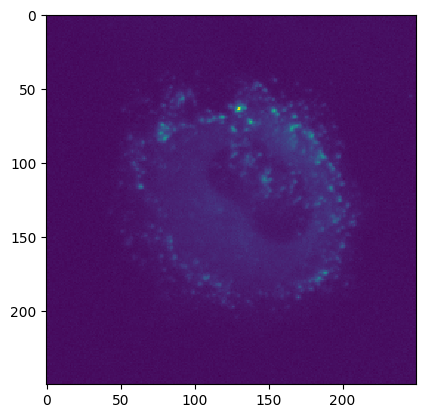

In [3]:
# load test image
dataset = ij.io().open('sample-data/test_image.tif')

# display test image (see the Working with Images for more info)
ij.py.show(dataset)

taking an image and applying a filter

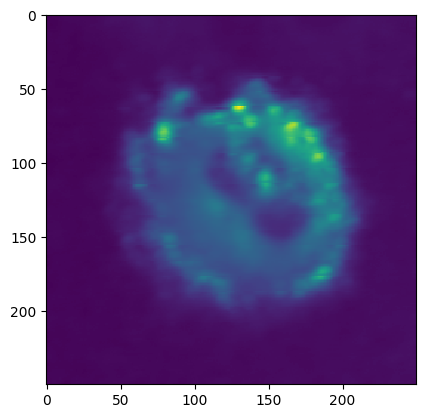

In [4]:
# import HyperSphereShape and create radius of 5
HyperSphereShape = jimport('net.imglib2.algorithm.neighborhood.HyperSphereShape')
radius = HyperSphereShape(5)

# apply filter
result = ij.dataset().create(dataset)
ij.op().filter().mean(result, dataset, radius)

# show image
ij.py.show(result)

# 3. Converting between Java and Python

**Important Caveat!**


converting a NumPy array to Java creates a Java object that points to the NumPy array.


This means that changing the Java object also changes the NumPy array.


However, when going from a Java object to a python object, a copy is made, meaning that any changes to the python version won't change the Java version (Currently being worked on fixing)

In [5]:
# converting a python list to Java

# create lists
python_list = [1, 2, 3, 4]
java_list = ij.py.to_java(python_list)

# modify one list
python_list[0] = 4

# check list contents
print(f"python_list: {python_list}\njava_list: {java_list}")

python_list: [4, 2, 3, 4]
java_list: [1, 2, 3, 4]


A java list can also be accessed just like a python list

In [6]:
print('List Values:')
for i in range(len(python_list)):
    print(f'python: {python_list[i]}, java: {java_list[i]}')    

List Values:
python: 4, java: 1
python: 2, java: 2
python: 3, java: 3
python: 4, java: 4


Note: ij.py.to_java() is not the only way to create a Java list/arrray. You can specifically create Java arrays by calling JPype’s JArray and JInt:

In [7]:
from jpype import JArray, JInt

java_int_array = JArray(JInt)([1, 2, 3, 4])

print(f"type: {type(java_int_array)}\nvalue: {java_int_array}")

type: <java class 'int[]'>
value: [1, 2, 3, 4]


3.3 Converting NumPy arrays to Java

In [8]:
import numpy as np

# get numpy array and list
test_arr = np.array([[5, 12], [21, 32]])
test_list = [1, 2, 4, 8, 16, 32, 64]

# convert array and list to Java
jarr = ij.py.to_java(test_arr)
jlist = ij.py.to_java(python_list)

print(type(jarr))
print(type(jlist))

<java class 'net.imagej.DefaultDataset'>
<java class 'java.util.ArrayList'>


We can check that jarr is a RandomAccessibleInterval by checking it against the Java class with isinstance. By contrast jlist should evaluate as False as it is not a RandomAcessibleInterval.

In [9]:
import scyjava as sj

# import RandomAccessibleInterval class
RandomAccessibleInterval = sj.jimport('net.imglib2.RandomAccessibleInterval')

print(f"jarr: {isinstance(jarr, RandomAccessibleInterval)}")
print(f"jlist: {isinstance(jlist, RandomAccessibleInterval)}")

jarr: True
jlist: False


ij.py.to_java() also works to convert NumPy arrays into ImageJ types. Let’s grab an image:

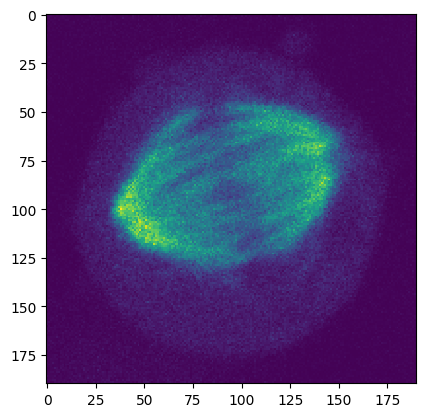

In [18]:
# Import an image with scikit-image.
# NB: 4D (X, Y, Channel, Z) confocal image of a HeLa cell in metaphase.
import skimage
io.imread

url = 'sample-data/metaphase_hela_cell.tif'
img = io.imread(url)
# get microtubule slice
# NB: The dimension shape of `img` is (pln, row, col, ch) or (Z, Y, X, Channel).
mt = img[0, :, :, 2]

# show image
ij.py.show(mt)

Any Op that requires a RandomAccessibleInterval can run on a NumPy array that has been passed to to_java(). Remember that this method creates a view, meaning that the Op is modifying the underlying Python object:

Let’s run a Difference of Gaussians on our numpy image using ImageJ:

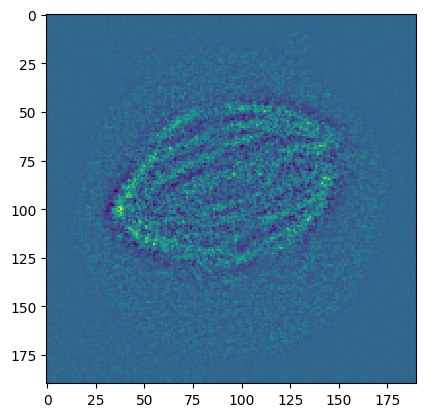

In [20]:
result = np.zeros(mt.shape)
# these sigmas will be nice for the larger sections
sigma1 = 2.5
sigma2 = 0.5
# note the use of to_java on img and result to turn the numpy images into RAIs
ij.op().filter().dog(ij.py.to_java(result), ij.py.to_java(mt), sigma1, sigma2)
# purple highlights the edges of the vessels, green highlights the centers
ij.py.show(result, cmap = 'viridis')

# 4 Converting from Java: ij.py.from_java()

ij.py.from_java() works in reverse of ij.py.to_java() and can be used to further process ImageJ data types with xarray, NumPy, scikit-image, etc.

First let’s initialize ImageJ and open an image from a URL with ImageJ and convert it into Python object. In thise case an xarray.DataArray.

### 4.1 converting between java and python


| Java | Python |
|------|--------|
| net.imglib2.python.ReferenceGuardingRandomAccessibleInterval | numpy.ndarray |
| net.imagej.Dataset | xarray.DataArray |
| java.lang.String | str |
| java.lang.Integer | int |
| java.lang.Float | float |
| java.util.ArrayList | list |
| java.util.LinkedHashMap | dict |
| java.util.ArrayList | tuple |


ij.py.from_java() is capable of converting common Java/ImageJ/ImageJ2 data types into their Python and NumPy equivalents.



















### 4.2 Converting Java objects to Python

We can see how ij.py.from_java() works to convert Java objects to Python. In this section we will convert a sample image from Java to Python as an example. First we need to initialize ImageJ:

In [24]:
import imagej

# initialize imagej
ij = imagej.init(mode='interactive')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.14.0/Inactive


[java.lang.Enum.toString] [INFO] Populating metadata
[java.lang.Enum.toString] [INFO] Populating metadata


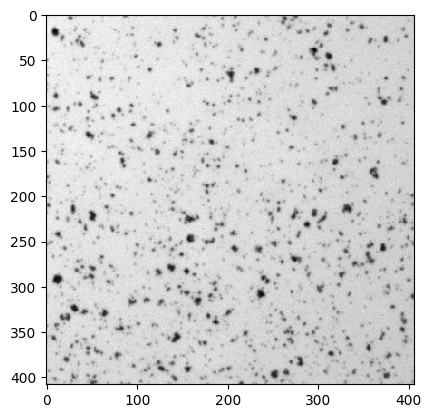

cell_colony type: <java class 'net.imagej.DefaultDataset'>
xr_colony type: <class 'xarray.core.dataarray.DataArray'>


In [25]:
# Load the image
url_colony = 'https://wsr.imagej.net/images/Cell_Colony.jpg'
cell_colony = ij.io().open(url_colony)

# Send the image to Python
xr_colony = ij.py.from_java(cell_colony)

# Display the image
ij.py.show(xr_colony, cmap='gray')

print(f"cell_colony type: {type(cell_colony)}")
print(f"xr_colony type: {type(xr_colony)}")

### 4.3 Special consideration: RGB and other axis conventions


NumPy/scikitimage dimension order is reverse indexed from ImageJ. ImageJ/ImgLib2 dimension order is [X, Y, Channel, Z, Time] by default. NumPy/scikitimage preferred dimension order is [t, pln, row, col, ch] where t = Time, pln = Z, row = Y, col = X and ch = Channel. Additionally, NumPy and matplotlib have a limited understanding of dimension/axis conventions and only natively handle 3-channel RGB images as [row, col, ch] or [Y, X, Channel]. To handle this difference in dimension/axis order preference, ImageJ images that are converted to output xarray.DataArray or numpy.ndarray have their re-ordered to match the destination order preference (retaining their metadata when possible).

In [26]:
# load 4D test data
dataset = ij.io().open('sample-data/test_timeseries.tif')

# get xarray
xarr = ij.py.from_java(dataset)

# print out shape and dimensions
print(f"dataset dims, shape: {dataset.dims}, {dataset.shape}")
print(f"xarr dims, shape: {xarr.dims}, {xarr.shape}")

dataset dims, shape: ('X', 'Y', 'Channel', 'Time'), (250, 250, 3, 15)
xarr dims, shape: ('t', 'row', 'col', 'ch'), (15, 250, 250, 3)


Lets look at an RGB image next:

In [32]:
import skimage
import numpy as np

# load the image
astro_img = skimage.data.astronaut()

# Convert the image to a numpy array
astro_arr = ij.py.from_java(astro_img)

print(astro_arr.shape)

(512, 512, 3)


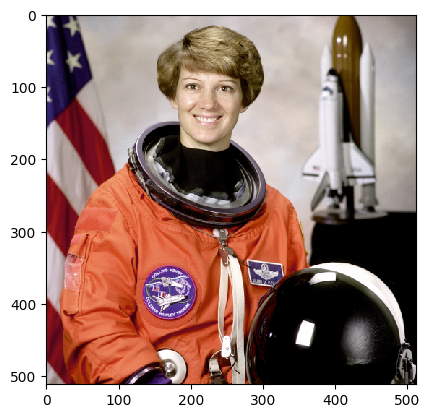

In [33]:
ij.py.show(astro_arr)

In [34]:
ij.ui().show(astro_arr)

TypeError: only integer scalar arrays can be converted to a scalar index

This error is because we're showing a numpy array in java

In [37]:
ij.py.to_dataset(astro_arr).shape # the channels now in the first dimension

(3, 512, 512)